Запуск из:

In [6]:
# Colab
folder_path = '/content/drive/MyDrive/2 Семестр/Курсовая СИИ/NEU-DET'
from google.colab import drive
drive.mount('/content/drive')

# Laptop
# folder_path = 'G:\Мой диск\2 Семестр\Курсовая СИИ\NEU-DET'

# Mac
# folder_path = '/Volumes/MacMini/Library/CloudStorage/GoogleDrive-dewuntain@gmail.com/Мой диск/2 Семестр/Курсовая СИИ/NEU-DET'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
from pathlib import Path

_images = '_images'
_ann = '_ann'

# Получаем список всех элементов в директории
all_items = os.listdir(folder_path)

folders = [os.path.join(folder_path, item) for item in all_items if os.path.isdir(os.path.join(folder_path, item))]

images_folders = [folder for folder in folders if folder.endswith("images")]
# ann_folders = [folder for folder in folders if folder.endswith("ann")]
folders_names = [os.path.basename(folder).replace(_images, '') for folder in images_folders]

for folder in folders_names:
  print(folder)


crazing
inclusion
patches
pitted_surface
scratches
rolled-in_scale


In [8]:
# Название дефекта
defect_name = folders_names[5]

# Название папки с изображениями
images_folder = defect_name + _images

# Путь до папки с изображениями
images_dir = os.path.join(folder_path, images_folder)

# Название изображения
image_file = defect_name + '_' + str(1) + '.jpg'

# Полный путь до изображеня
image_path = os.path.join(images_dir, image_file)

print(image_path)

/content/drive/MyDrive/2 Семестр/Курсовая СИИ/NEU-DET/rolled-in_scale_images/rolled-in_scale_1.jpg


In [9]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage import io, color, img_as_ubyte
from skimage import data, exposure, img_as_float
from skimage.filters import threshold_otsu
from skimage.feature import graycomatrix, graycoprops

# Для интерактивного использования в Jupyter:
from ipywidgets import interact, IntSlider

Метод для отображения аннотаций на изображениях

In [10]:
# ----------------- Отображение аннотаций на изображений -----------------
def draw_boxes_on_image(image, xml_path):
    """Рисует bounding boxes на изображении из XML"""
    image_with_boxes = image.copy()
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            cv2.rectangle(image_with_boxes, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    except Exception as e:
        print(f"Warning: Could not process XML annotation: {e}")

    return image_with_boxes


Общий метод для чтения изображений

In [11]:
# ----------------- Отдельный метод для чтения изображений -----------------
def load_images_and_boxes(image_path, components):
    """Загружает изображение и рисует bounding boxes из XML"""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = (gray_image * 255).astype(np.uint8)

    if components['contrast']:
      img_eq = exposure.equalize_adapthist(gray_image, clip_limit=components['clip_limit'], kernel_size=components['kernel_size'])
      gray_image = (img_eq * 255).astype(np.uint8)

    xml_path = image_path.replace("_images", "_ann").replace(".jpg", ".xml")

    if xml_path:
      image_with_boxes = draw_boxes_on_image(image, xml_path)
      return image, gray_image, image_with_boxes

    return image, gray_image, None

Тестирование контраста, при его использовании

In [12]:
# ----------------- Метод для подбора параметров контраста -----------------
def test_contrast(image_path, components):
  # 1) Загружаем изображение и конвертируем в grayscale
  image, gray_image, _ = load_images_and_boxes(image_path, components)

  # img_eq = exposure.equalize_adapthist(gray_image, clip_limit=0.01, kernel_size=(16, 16))
  img_eq = exposure.equalize_adapthist(gray_image, clip_limit=components['clip_limit'], kernel_size=components['kernel_size'])
  img_eq = (img_eq * 255).astype(np.uint8)

  # Применение Gaussian blur
  blurred_image = cv2.GaussianBlur(img_eq, (1, 1), 0)

  # Создание графики
  plt.figure(figsize=(12, 12))

  # 1. Изображение с bounding boxes
  plt.subplot(1, 4, 1)
  plt.imshow(image)
  plt.title('Image')
  plt.axis('off')

  # 2. Карта текстурных признаков
  plt.subplot(1, 4, 2)
  plt.imshow(gray_image, cmap='gray')
  plt.title(f'Gray')
  # plt.colorbar()
  plt.axis('off')

  # 3. Бинарные области
  plt.subplot(1, 4, 3)
  plt.imshow(img_eq, cmap='gray')
  plt.title(f'Contrast')
  plt.axis('off')

  # 3. Бинарные области
  plt.subplot(1, 4, 4)
  plt.imshow(blurred_image, cmap='gray')
  plt.title(f'Gaussian blur')
  plt.axis('off')

  plt.tight_layout()
  plt.show()
# test_contrast(image_path, components)

Построение одной карты

In [13]:
# ----------------- Отдельный метод для построения карты контраста -----------------
def create_texture_map(gray_image, components):
  """Создает карту текстурных признаков"""
  height, width = gray_image.shape
  texture_map = np.zeros_like(gray_image, dtype=np.float32)

  for y in range(0, height, components['step']):
    for x in range(0, width, components['step']):
      # Определяем границы окна (с обрезкой по краю изображения)
      y1 = y
      y2 = min(y + components['window_size'], height)
      x1 = x
      x2 = min(x + components['window_size'], width)

      window = gray_image[y1:y2, x1:x2]
      if window.shape[0] < 2 or window.shape[1] < 2:
          continue
      # Квантование уровней до 'levels'
      window_q = (window.astype(np.float32) / 255 * (components['levels'] - 1)).astype(np.uint8)

      # Строим GLCM для окна
      glcm = graycomatrix(
          window_q,
          distances=components['distances'],
          angles=components['angles'],
          levels=components['levels'],
          symmetric=components['symmetric'],
          normed=components['normed']
      )
      contrast = graycoprops(glcm, 'contrast').mean()

      texture_map[y1:y2, x1:x2] = contrast

  return cv2.normalize(texture_map, None, 0, 255, cv2.NORM_MINMAX)

In [14]:
# ----------------- Общий метод для построения и визуализации тепловой карты -----------------
def calculate_with_otsu_or_upper_threshold_value(image_path,
                                                 components,
                                                 to_save_path=None
                                                 ):

  # 1) Загружаем изображение и конвертируем в grayscale
  image, gray_image, image_with_boxes = load_images_and_boxes(image_path, components)

  # 2) Создание текстурной карты
  map = create_texture_map(gray_image, components)

  threshold_value = 0
  if components['threshold_value'] == 0:
    # Применяем пороговую обработку (метод Оцу)
    threshold_value = threshold_otsu(map)
  else:
    threshold_value = components['threshold_value']

  # Бинаризация текстурной карты
  binary_texture = (map > threshold_value).astype(np.uint8) * 255

  # # Создаем маску для выделения областей
  # mask = np.zeros_like(image)
  # for i in range(3):
  #   mask[:,:,i] = binary_texture

  # Находим контуры на бинарной маске
  contours, _ = cv2.findContours(binary_texture, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Создаем пустую маску того же размера
  mask = np.zeros_like(gray_image)

  # Рисуем контуры белым цветом (или любым другим) на каждом канале маски
  cv2.drawContours(mask, contours, -1, color=(255, 255, 255), thickness=2)




  # Наложение маски на оригинальное изображение
  highlighted = cv2.addWeighted(gray_image, 0.9, mask, 0.1, 0)


  # Создаем фигуру
  plt.figure(figsize=(12, 10))

  # 1. Grayscale изображение
  plt.subplot(2, 2, 1)
  # plt.imshow(image_with_boxes,)
  # plt.title('Original Image with boxes')
  plt.imshow(gray_image, cmap='gray')
  plt.title('Gray Image')
  plt.axis('off')

  # 2. Карта текстурных признаков
  plt.subplot(2, 2, 2)
  plt.imshow(map, cmap='jet')
  plt.title('Texture Feature Map (Contrast)')
  plt.colorbar()
  plt.axis('off')

  # 3. Бинарная маска на изображении
  plt.subplot(2, 2, 3)
  plt.imshow(highlighted, cmap='gray')
  plt.title('Highlighted Texture Regions')
  plt.axis('off')

  # 4. Только бинарная маска
  plt.subplot(2, 2, 4)

  # Создание бинарной маски с нарисованными bounding boxes
  binary_with_boxes = cv2.cvtColor(binary_texture, cv2.COLOR_GRAY2RGB)
  xml_path = image_path.replace("_images", "_ann").replace(".jpg", ".xml")
  binary_with_boxes = draw_boxes_on_image(binary_with_boxes, xml_path)

  # plt.imshow(binary_texture, cmap='gray')
  plt.imshow(binary_with_boxes)

  plt.title(f'Binary Texture Regions (Threshold={threshold_value:.1f})')
  plt.axis('off')

  plt.suptitle(
  f"calculate_with_otsu_or_upper_threshold_value\nImage: {os.path.basename(image_path)}\nWindow_size x Step: {components['window_size']}x{components['step']}",
  fontsize=16,
  y=1.0)

  plt.tight_layout()

  if to_save_path:
      os.makedirs(to_save_path, exist_ok=True)
      img_name = os.path.splitext(os.path.basename(image_path))[0]
      output_path = os.path.join(to_save_path, f"{img_name}_texture_analysis.png")
      plt.savefig(output_path, dpi=components['dpi'], bbox_inches='tight')
      plt.close()
  else:
      plt.show()

In [15]:
# ----------------- Общий метод для построения и визуализации тепловой карты -----------------
def calculate_with_otsu_or_lower_threshold_value(image_path,
                                                 components,
                                                 to_save_path=None
                                                 ):

  # 1) Загружаем изображение и конвертируем в grayscale
  image, gray_image, image_with_boxes = load_images_and_boxes(image_path, components)

  # 2) Создание текстурной карты
  map = create_texture_map(gray_image, components)

  threshold_value = 0
  if components['threshold_value'] == 0:
    # Применяем пороговую обработку (метод Оцу)
    threshold_value = threshold_otsu(map)
  else:
    threshold_value = components['threshold_value']

  # Бинаризация текстурной карты
  binary_texture = (map < threshold_value).astype(np.uint8) * 255

  # # Создаем маску для выделения областей
  # mask = np.zeros_like(image)
  # for i in range(3):
  #   mask[:,:,i] = binary_texture

  # Находим контуры на бинарной маске
  contours, _ = cv2.findContours(binary_texture, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Создаем пустую маску того же размера
  mask = np.zeros_like(gray_image)

  # Рисуем контуры белым цветом (или любым другим) на каждом канале маски
  cv2.drawContours(mask, contours, -1, color=(255, 255, 255), thickness=2)




  # Наложение маски на оригинальное изображение
  highlighted = cv2.addWeighted(gray_image, 0.9, mask, 0.1, 0)


  # Создаем фигуру
  plt.figure(figsize=(12, 10))

  # 1. Grayscale изображение
  plt.subplot(2, 2, 1)
  # plt.imshow(image_with_boxes,)
  # plt.title('Original Image with boxes')
  plt.imshow(gray_image, cmap='gray')
  plt.title('Gray Image')
  plt.axis('off')

  # 2. Карта текстурных признаков
  plt.subplot(2, 2, 2)
  plt.imshow(map, cmap='jet')
  plt.title('Texture Feature Map (Contrast)')
  plt.colorbar()
  plt.axis('off')

  # 3. Бинарная маска на изображении
  plt.subplot(2, 2, 3)
  plt.imshow(highlighted, cmap='gray')
  plt.title('Highlighted Texture Regions')
  plt.axis('off')

  # 4. Только бинарная маска
  plt.subplot(2, 2, 4)

  # Создание бинарной маски с нарисованными bounding boxes
  binary_with_boxes = cv2.cvtColor(binary_texture, cv2.COLOR_GRAY2RGB)
  xml_path = image_path.replace("_images", "_ann").replace(".jpg", ".xml")
  binary_with_boxes = draw_boxes_on_image(binary_with_boxes, xml_path)

  # plt.imshow(binary_texture, cmap='gray')
  plt.imshow(binary_with_boxes)

  plt.title(f'Binary Texture Regions (Threshold={threshold_value:.1f})')
  plt.axis('off')

  plt.suptitle(
  f"calculate_with_otsu_or_lower_threshold_value\nImage: {os.path.basename(image_path)}\nWindow_size x Step: {components['window_size']}x{components['step']}",
  fontsize=16,
  y=1.0)

  plt.tight_layout()

  if to_save_path:
      os.makedirs(to_save_path, exist_ok=True)
      img_name = os.path.splitext(os.path.basename(image_path))[0]
      output_path = os.path.join(to_save_path, f"{img_name}_texture_analysis.png")
      plt.savefig(output_path, dpi=components['dpi'], bbox_inches='tight')
      plt.close()
  else:
      plt.show()

In [16]:
components = {
    'window_size': 10,
    'step': 5,

    'distances': [1, 3, 5, 7, 9],
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],
    'levels': 32,
    # 'levels': 256,
    'symmetric': True,
    'normed': True,

    'properties': ['contrast',
                   'dissimilarity',
                   'homogeneity',
                   'energy',
                   'correlation',
                   'ASM'],

    'contrast': False,
    'clip_limit': 0.001,
    # clip_limit=0.03
    'kernel_size': (16,16),

    'threshold_value': 0,
    'dpi': 100
    }

In [17]:
# components['distances'] = components['distances'][:5]
# print(components['distances'])

# components['angles'] = components['angles'][:4]
# print(components['angles'])

# components['properties'] = components['properties'][:6]
# print(components['properties'])

crazing

inclusion

patches

pitted_surface

scratches

rolled-in_scale

In [32]:
image_path = folder_path + "/pitted_surface_images/pitted_surface_41.jpg"

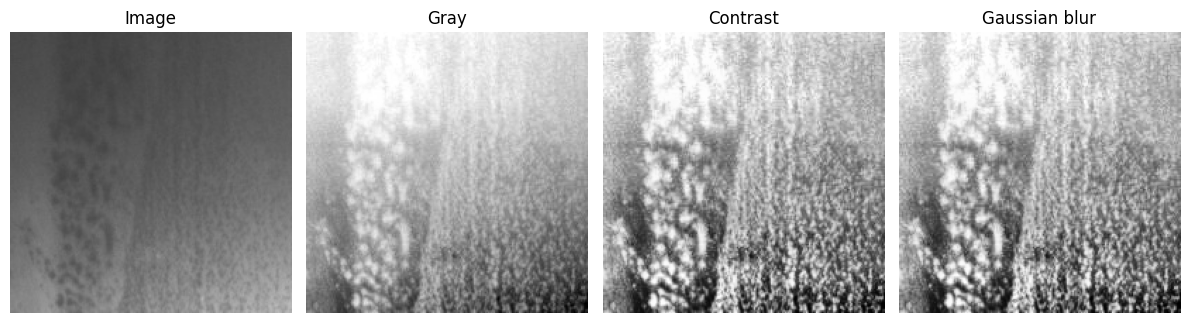

In [19]:
components['contrast'] = True
components['clip_limit'] = 0.01
kernel = 32
components['kernel_size'] = (kernel,kernel)

test_contrast(image_path, components)

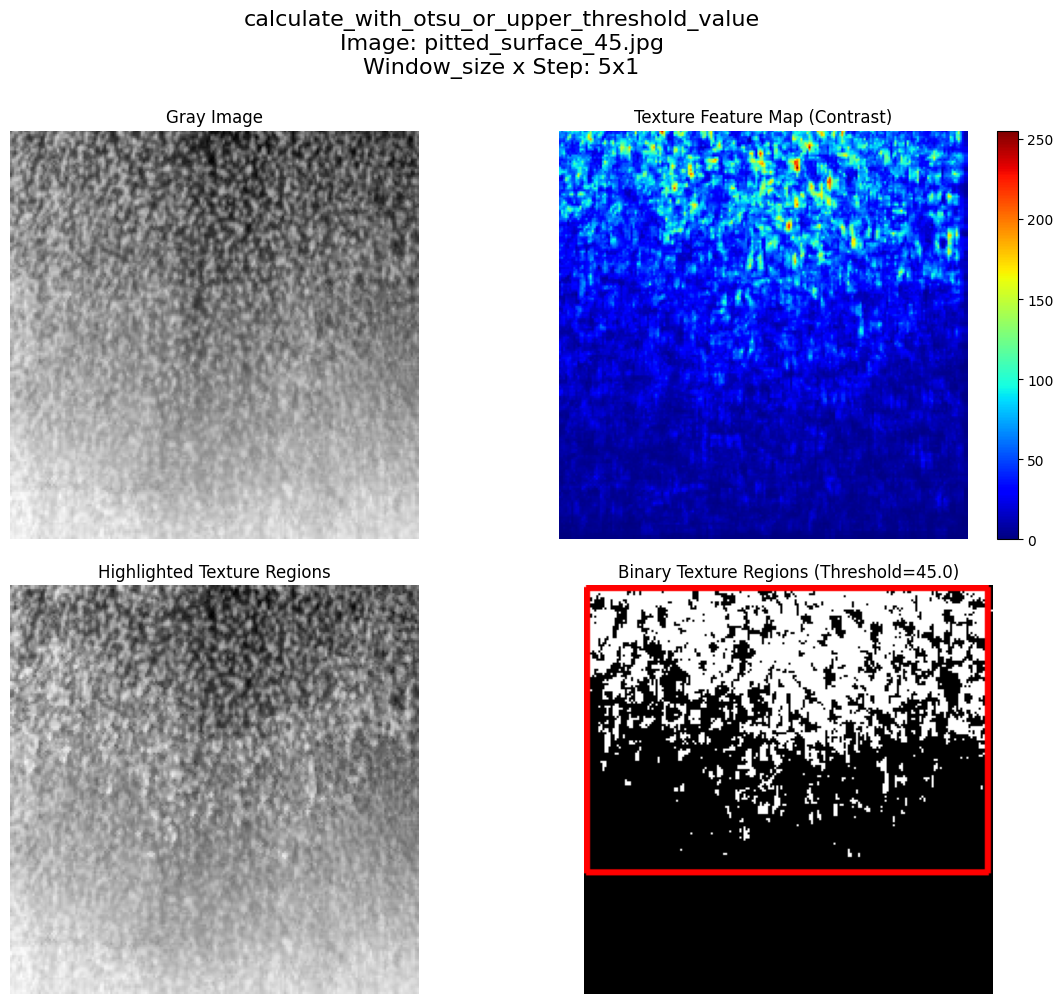

In [45]:
image_path = folder_path + "/pitted_surface_images/pitted_surface_45.jpg"

components['window_size'] = 5
components['step'] = 1

# components['window_size'] = 5
# components['step'] = 3

# components['window_size'] = 7
# components['step'] = 3

components['threshold_value'] = 45
calculate_with_otsu_or_upper_threshold_value(image_path = image_path,
                                             components = components,
                                             to_save_path=None
                                             )

In [ ]:
image_path = folder_path + "/patches_images/patches_82.jpg"

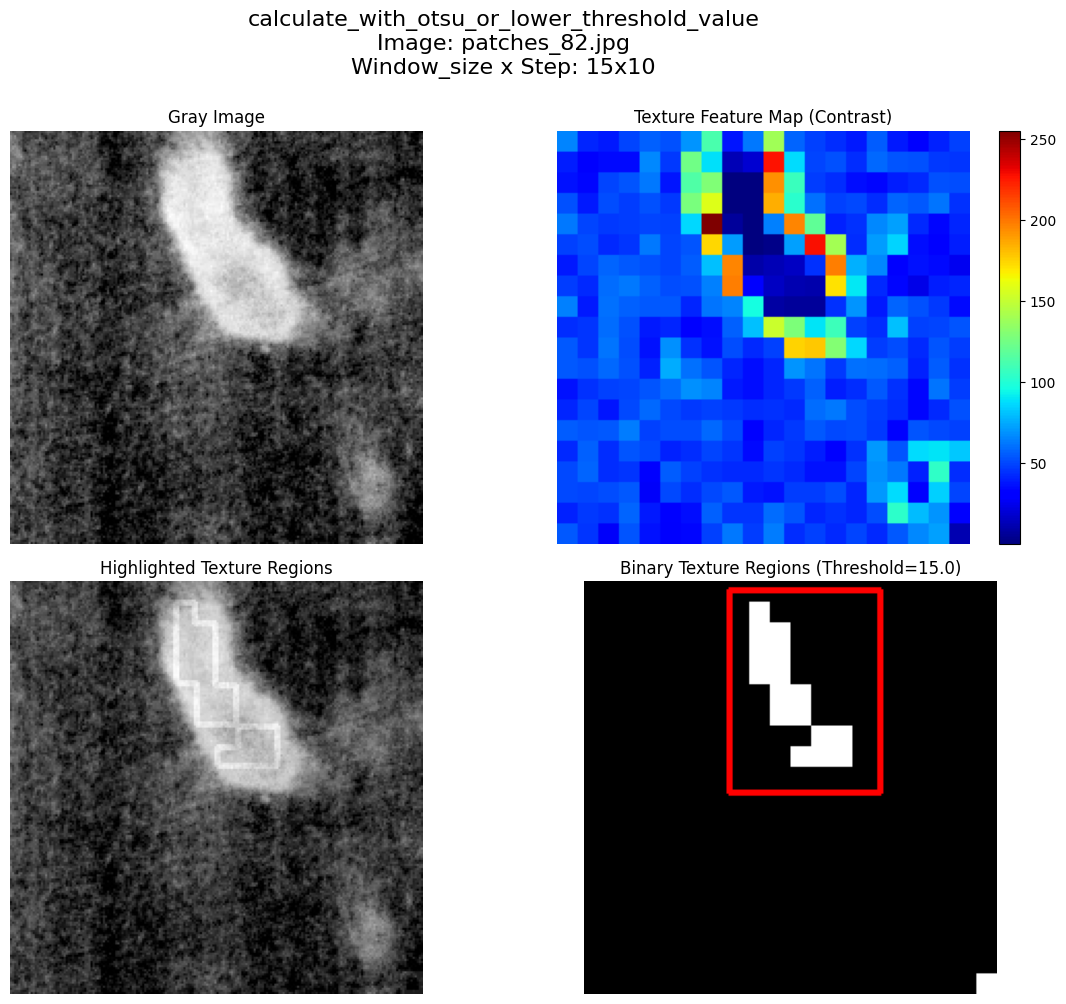

In [ ]:
components['window_size'] = 5
components['step'] = 3

components['window_size'] = 10
components['step'] = 5

components['window_size'] = 15
components['step'] = 10

components['threshold_value'] = 15
calculate_with_otsu_or_lower_threshold_value(image_path = image_path,
                                             components = components,
                                             to_save_path=None
                                             )

In [24]:
to_save_dir = 'pitted_surface_5_1_new_2'
to_save_path = os.path.join(folder_path, to_save_dir)
print(to_save_path)

/content/drive/MyDrive/2 Семестр/Курсовая СИИ/NEU-DET/pitted_surface_5_1_new_2


Получение результатов в цикле

In [ ]:
for folder in folders_names:
  # Название папки
  folder_name = folder + _images

  # Полный путь до папки
  images_dir = os.path.join(folder_path, folder_name)

  for i in range(1,301,20):
    # Название изображения
    image_name = folder + '_' + str(i) + '.jpg'

    # Полный путь до изображения
    images_full_path = os.path.join(images_dir, image_name)

    # Переменная с путем
    image_path = images_full_path

    calculate_with_otsu_or_upper_threshold_value(image_path = image_path,
                                                 components = components,
                                                 #  to_save_path=None
                                                 to_save_path=to_save_path)

  print(f'End : {folder_name}')
print('All End!')

IndentationError: unexpected indent (<ipython-input-177-2918512400>, line 2)

In [22]:
print(folders_names[3])

pitted_surface


In [25]:
folder = folders_names[3]
# Название папки
folder_name = folder + _images

# Полный путь до папки
images_dir = os.path.join(folder_path, folder_name)

for i in range(10,301,20):
# for i in range(1,301):
  # Название изображения
  image_name = folder + '_' + str(i) + '.jpg'

  # Полный путь до изображения
  images_full_path = os.path.join(images_dir, image_name)

  # Переменная с путем
  image_path = images_full_path

  calculate_with_otsu_or_upper_threshold_value(image_path = image_path,
                                                components = components,
                                                #  to_save_path=None
                                                to_save_path=to_save_path)

Построение всех 6 карт контраста

In [ ]:
# ----------------- Отдельный метод для построения карт признаков GLCM -----------------

def create_contrast_map(gray_image, components):
    """
    Возвращает карту контраста (Contrast) для каждого окна изображения.
    """
    height, width = gray_image.shape

    # Создаем словарь пустых карт под каждое запрошенное свойство
    feature_maps = {}
    for p in components['properties']:
        feature_maps[p] = np.zeros((height, width), dtype=np.float32)

    # contrast_map = np.zeros((height, width), dtype=np.float32)

    for y in range(0, height, components['step']):
        for x in range(0, width, components['step']):
            # Определяем границы окна (с обрезкой по краю изображения)
            y1 = y
            y2 = min(y + components['window_size'], height)
            x1 = x
            x2 = min(x + components['window_size'], width)

            window = gray_image[y1:y2, x1:x2]
            if window.shape[0] < 2 or window.shape[1] < 2:
                continue

            # Квантование уровней до 'levels'
            window_q = (window.astype(np.float32) / 255 * (components['levels'] - 1)).astype(np.uint8)

            # Строим GLCM для окна
            glcm = graycomatrix(
                window_q,
                distances=components['distances'],
                angles=components['angles'],
                levels=components['levels'],
                symmetric=components['symmetric'],
                normed=components['normed']
            )

            # Для каждого запрошенного свойства вычисляем значение и заполняем регион
            for prop in components['properties']:
                val = graycoprops(glcm, prop=prop)[0, 0]
                feature_maps[prop][y1:y2, x1:x2] = val

    # Нормализуем каждую карту в диапазон [0, 255] и приводим к uint8
    for prop in components['properties']:
        feature_maps[prop] = cv2.normalize(
            feature_maps[prop], None, alpha=0, beta=255,
            norm_type=cv2.NORM_MINMAX
        ).astype(np.uint8)

    return feature_maps

In [ ]:
# ----------------- Общий метод для построения и визуализации всех карт -----------------

def calculate_and_display_feature_maps(image_path,
                                       components,
                                       to_save_path=None
                                       ):
    # 1) Загружаем изображение и конвертируем в grayscale
    image, gray_image, image_with_boxes = load_images_and_boxes(image_path, components)

    # 2) Строим каждую карту
    maps = create_contrast_map(gray_image, components)

    # 3) Визуализация всех карт
    num_maps = len(components['properties'])
    total_plots = num_maps + 3

    cols = 3
    rows = (total_plots + cols - 1) // cols  # округление вверх

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.ravel()

    # 4) Рисуем GLCM-карты
    for i, prop in enumerate(components['properties']):
        axes[i].imshow(maps[prop], cmap='jet')
        axes[i].set_title(f'{prop.capitalize()} Map')
        axes[i].axis('off')

    # 5) Добавляем изображения
    axes[num_maps].imshow(image)
    axes[num_maps].set_title('Original Image')
    axes[num_maps].axis('off')

    axes[num_maps + 1].imshow(image_with_boxes)
    axes[num_maps + 1].set_title('Image with Bounding Boxes')
    axes[num_maps + 1].axis('off')

    axes[num_maps + 2].imshow(gray_image, cmap='gray')
    axes[num_maps + 2].set_title('Grayscale Image')
    axes[num_maps + 2].axis('off')

    # Удалить лишние оси, если не все субплоты заняты
    for j in range(num_maps + 3, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(
    f"Image: {os.path.basename(image_path)}\nWindow_size x Step: {components['window_size']}x{components['step']}",
    fontsize=16,
    y=1.0)

    plt.tight_layout()

    if to_save_path:
        os.makedirs(to_save_path, exist_ok=True)
        img_name = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(to_save_path, f"{img_name}_texture_analysis.png")
        plt.savefig(output_path, dpi=components['dpi'], bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
components = {
    'window_size': 15,
    'step': 5,

    'distances': [1, 3, 5, 7, 9],
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],
    'levels': 32,
    # 'levels': 256,
    'symmetric': True,
    'normed': True,

    'properties': ['contrast',
                   'dissimilarity',
                   'homogeneity',
                   'energy',
                   'correlation',
                   'ASM'],

    'contrast': False,
    'clip_limit': 0.001,
    # clip_limit=0.03
    'kernel_size': (16,16),

    'threshold_value': 0,
    'dpi': 100
    }

In [ ]:
components['distances'] = components['distances'][:5]
print(components['distances'])

components['angles'] = components['angles'][:4]
print(components['angles'])

components['properties'] = components['properties'][:6]
print(components['properties'])

[1, 3, 5, 7, 9]
[0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345]
['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']


In [ ]:
image_path = folder_path + "/crazing_images/crazing_241.jpg"

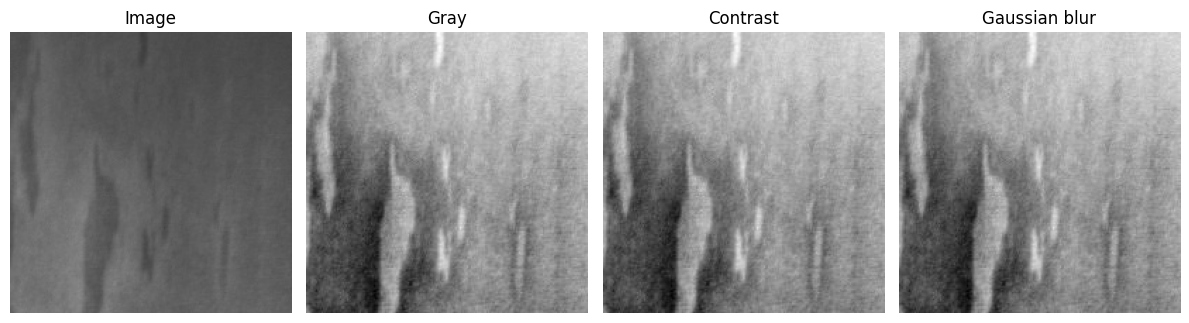

In [ ]:
test_contrast(image_path, components)

In [ ]:
print(components['angles'])
components['angles'] = [components['angles'][1]]
print(components['angles'])

[0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345]
[0.7853981633974483]


In [ ]:
components['window_size'] = 5
components['step'] = 1

# components['window_size'] = 5
# components['step'] = 3

# components['window_size'] = 7
# components['step'] = 3


# components['threshold_value'] = 70

calculate_and_display_feature_maps(image_path = image_path,
                                   components = components,
                                   to_save_path=None
                                   )


Output hidden; open in https://colab.research.google.com to view.

In range

In [ ]:
to_save_dir = 'test_start_2'
to_save_path = os.path.join(folder_path, to_save_dir)

for folder in folders_names:
  # Название папки
  folder_name = folder + _images

  # Полный путь до папки
  images_dir = os.path.join(folder_path, folder_name)

  for i in range(2,301, 75):
    # Название изображения
    image_name = folder + '_' + str(i) + '.jpg'

    # Полный путь до изображения
    images_full_path = os.path.join(images_dir, image_name)

    # Переменная с путем
    image_path = images_full_path

    calculate_and_display_feature_maps(image_path = image_path,
                                       components = components,
                                      #  to_save_path=None
                                       to_save_path=to_save_path
                                       )

  print(f'End : {folder_name}')
print('All End!')

End : crazing_images
End : inclusion_images
End : patches_images
End : pitted_surface_images
End : scratches_images
End : rolled-in_scale_images
All End!


In [ ]:
# ----------------- Отдельный метод для построения карты контраста -----------------
def create_texture_map_energy(gray_image, components):
  """Создает карту текстурных признаков"""
  height, width = gray_image.shape
  texture_map = np.zeros_like(gray_image, dtype=np.float32)

  for y in range(0, height, components['step']):
    for x in range(0, width, components['step']):
      # Определяем границы окна (с обрезкой по краю изображения)
      y1 = y
      y2 = min(y + components['window_size'], height)
      x1 = x
      x2 = min(x + components['window_size'], width)

      window = gray_image[y1:y2, x1:x2]
      if window.shape[0] < 2 or window.shape[1] < 2:
          continue
      # Квантование уровней до 'levels'
      window_q = (window.astype(np.float32) / 255 * (components['levels'] - 1)).astype(np.uint8)

      # Строим GLCM для окна
      glcm = graycomatrix(
          window_q,
          distances=components['distances'],
          angles=components['angles'],
          levels=components['levels'],
          symmetric=components['symmetric'],
          normed=components['normed']
      )
      energy = graycoprops(glcm, 'energy').mean()

      texture_map[y1:y2, x1:x2] = energy

  return cv2.normalize(texture_map, None, 0, 255, cv2.NORM_MINMAX)

In [ ]:
# ----------------- Общий метод для построения и визуализации тепловой карты -----------------
def calculate_with_otsu_or_lower_threshold_value_energy(image_path,
                                                 components,
                                                 to_save_path=None
                                                 ):

  # 1) Загружаем изображение и конвертируем в grayscale
  image, gray_image, image_with_boxes = load_images_and_boxes(image_path, components)

  # 2) Создание текстурной карты
  map = create_texture_map_energy(gray_image, components)

  threshold_value = 0
  if components['threshold_value'] == 0:
    # Применяем пороговую обработку (метод Оцу)
    threshold_value = threshold_otsu(map)
  else:
    threshold_value = components['threshold_value']

  # Бинаризация текстурной карты
  binary_texture = (map < threshold_value).astype(np.uint8) * 255

  # # Создаем маску для выделения областей
  # mask = np.zeros_like(image)
  # for i in range(3):
  #   mask[:,:,i] = binary_texture

  # Находим контуры на бинарной маске
  contours, _ = cv2.findContours(binary_texture, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Создаем пустую маску того же размера
  mask = np.zeros_like(gray_image)

  # Рисуем контуры белым цветом (или любым другим) на каждом канале маски
  cv2.drawContours(mask, contours, -1, color=(255, 255, 255), thickness=2)




  # Наложение маски на оригинальное изображение
  highlighted = cv2.addWeighted(gray_image, 0.9, mask, 0.1, 0)


  # Создаем фигуру
  plt.figure(figsize=(12, 10))

  # 1. Grayscale изображение
  plt.subplot(2, 2, 1)
  # plt.imshow(image_with_boxes,)
  # plt.title('Original Image with boxes')
  plt.imshow(gray_image, cmap='gray')
  plt.title('Gray Image')
  plt.axis('off')

  # 2. Карта текстурных признаков
  plt.subplot(2, 2, 2)
  plt.imshow(map, cmap='jet')
  plt.title('Texture Feature Map (Energy)')
  plt.colorbar()
  plt.axis('off')

  # 3. Бинарная маска на изображении
  plt.subplot(2, 2, 3)
  plt.imshow(highlighted, cmap='gray')
  plt.title('Highlighted Texture Regions')
  plt.axis('off')

  # 4. Только бинарная маска
  plt.subplot(2, 2, 4)

  # Создание бинарной маски с нарисованными bounding boxes
  binary_with_boxes = cv2.cvtColor(binary_texture, cv2.COLOR_GRAY2RGB)
  xml_path = image_path.replace("_images", "_ann").replace(".jpg", ".xml")
  binary_with_boxes = draw_boxes_on_image(binary_with_boxes, xml_path)

  # plt.imshow(binary_texture, cmap='gray')
  plt.imshow(binary_with_boxes)

  plt.title(f'Binary Texture Regions (Threshold={threshold_value:.1f})')
  plt.axis('off')

  plt.suptitle(
  f"calculate_with_otsu_or_lower_threshold_value(energy)\nImage: {os.path.basename(image_path)}\nWindow_size x Step: {components['window_size']}x{components['step']}",
  fontsize=16,
  y=1.0)

  plt.tight_layout()

  if to_save_path:
      os.makedirs(to_save_path, exist_ok=True)
      img_name = os.path.splitext(os.path.basename(image_path))[0]
      output_path = os.path.join(to_save_path, f"{img_name}_texture_analysis.png")
      plt.savefig(output_path, dpi=components['dpi'], bbox_inches='tight')
      plt.close()
  else:
      plt.show()

In [ ]:
components = {
    'window_size': 15,
    'step': 5,

    'distances': [1, 3, 5, 7, 9],
    'angles': [0, np.pi/4, np.pi/2, 3*np.pi/4],
    'levels': 32,
    # 'levels': 256,
    'symmetric': True,
    'normed': True,

    'properties': ['contrast',
                   'dissimilarity',
                   'homogeneity',
                   'energy',
                   'correlation',
                   'ASM'],

    'contrast': False,
    'clip_limit': 0.001,
    # clip_limit=0.03
    'kernel_size': (16,16),

    'threshold_value': 0,
    'dpi': 100
    }

In [ ]:
image_path = folder_path + "/crazing_images/crazing_241.jpg"

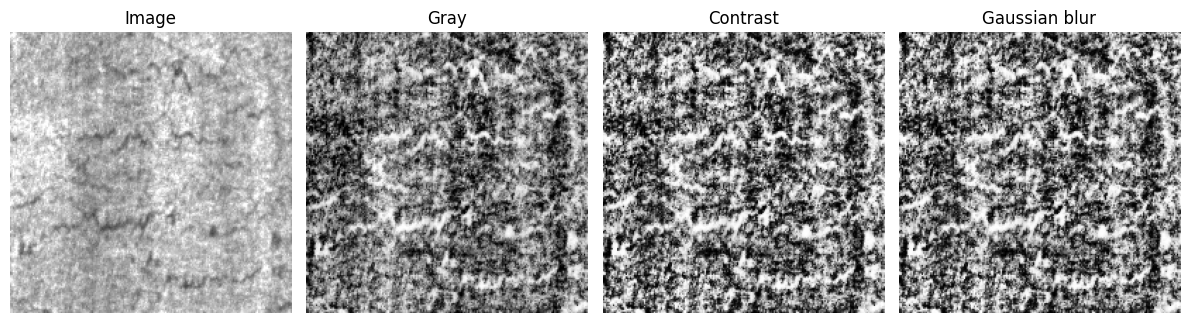

In [ ]:
components['contrast'] = True
components['clip_limit'] = 0.01
kernel = 32
components['kernel_size'] = (kernel,kernel)

test_contrast(image_path, components)

In [ ]:
print(components['angles'])
components['angles'] = [components['angles'][1]]
print(components['angles'])

[0.7853981633974483]


IndexError: list index out of range

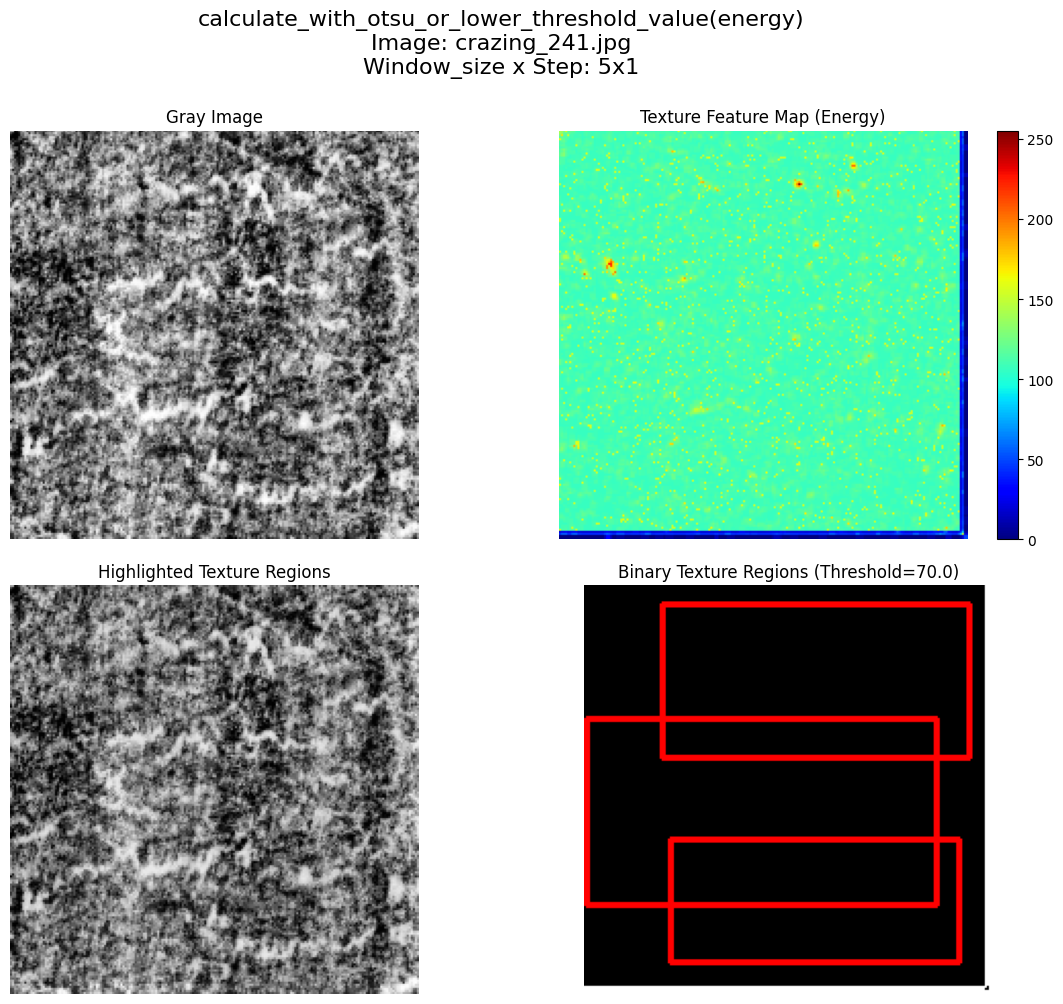

In [ ]:
components['window_size'] = 5
components['step'] = 1

# components['window_size'] = 5
# components['step'] = 3

# components['window_size'] = 7
# components['step'] = 3


components['threshold_value'] = 70
calculate_with_otsu_or_lower_threshold_value_energy(image_path = image_path,
                                                    components = components,
                                                    to_save_path=None
                                                    )
